<a href="https://colab.research.google.com/github/chasubeen/python_selfstudy/blob/master/deep_pytorch/7.%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%20%EC%8A%A4%ED%83%80%EC%9D%BC%20%EC%A0%84%EC%9D%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **파이토치에서 신경망을 이용한 스타일 전이 구현하기**

## **콘텐츠와 스타일 이미지 로딩**

### **(a) Import Libraries**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **(b) 이미지 준비**
- 스타일 이미지와 콘텐츠 이미지 준비

In [5]:
### 이미지를 텐서로 로딩

def image_to_tensor(image_filepath, image_dimension = 128):
  img = Image.open(image_filepath).convert('RGB')

  # display image to check
  plt.figure()
  plt.title(image_filepath.split('/')[-1])
  plt.imshow(img)

  # 범위 지정
  if image_dimension >= max(img.size):
    img_size = max(img.size)
  else:
    img_size = image_dimension

  # 이미지 전처리(가공)
  torch_transformation = torchvision.transforms.Compose([
      torchvision.transforms.Resize(img_size),
      torchvision.transforms.ToTensor()
  ])

  img = torch_transformation(img).unsqueeze(0)

  return img.to(dvc, torch.float)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


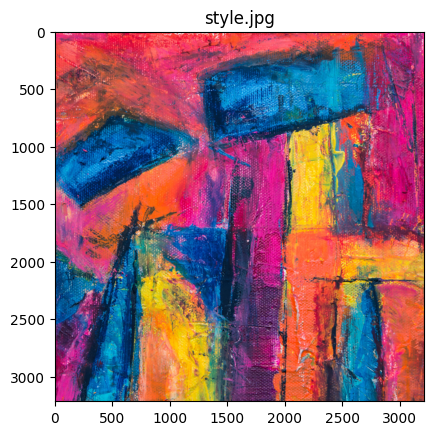

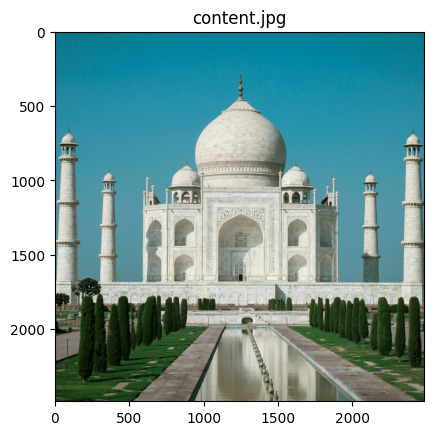

In [7]:
style_image = image_to_tensor("/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/chapter7_imgs/style.jpg")
content_image = image_to_tensor("/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/chapter7_imgs/content.jpg")

- content: 타지마할
- style: 예술 작품

## **사전 훈련된 VGG19 모델 로딩/조정**
- 사전 훈련된 VGG19 모델 로딩
- 콘텐츠 손실과 스타일 손실을 계산하기 위해 합성곱 계층을 사용
  - 콘텐츠 타깃과 스타일 타깃 생성

In [8]:
vgg19_model = torchvision.models.vgg19(pretrained = True).to(dvc)
print(vgg19_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
### 합성곱 계층만 선택

vgg19_model = vgg19_model.features

In [10]:
### 매개변수 고정
# 해당 실습에서는 VGG 모델의 매개변수를 튜닝하지 x
# -> 모델의 입력단에서 생성된 이미지의 픽셀만 튜닝함

for param in vgg19_model.parameters():
  param.requires_grad_(False)

In [11]:
### 풀링 계층 변경
# max-pooling -> avg-pooling

conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                      stride=vgg19_model[i].stride,
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

- 선형 계층은 제거되었고 최대 풀링 계층은 평균 풀링 계층으로 교체되었음

## **신경망 스타일 전이 모델 구축**
- 콘텐츠 손실과 스타일 손실을 어느 계층에서 계산할 것인지 정의

### **(a) 계층 정의**
- 스타일 손실과 콘텐츠 손실을 계산해야 할 계층을 리스트로 생성

In [12]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

- 스타일 손실) 1 ~ 5번째 합성곱 계층
- 콘텐츠 손실) 4번째 합성곱 계층

### **(b) 필요한 부분 선택**
- 모델에서 불필요한 부분을 제거하자.

In [13]:
vgg_layers = nn.ModuleList(vgg19_model)

last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


- 16개 합성곱 계층으로 구성된 VGG 모델 -> 5개 합성곱 계층으로 구성된 신경망 스타일 전이 모델로 전환

## **신경망 전이 모델 훈련**
- 생성될 이미지 개선
  - 이미지 초기화 -> 랜덤 노이즈 이미지 활용


### **(a) 랜덤 노이즈**
- torch 텐서를 랜덤 숫자로 초기화

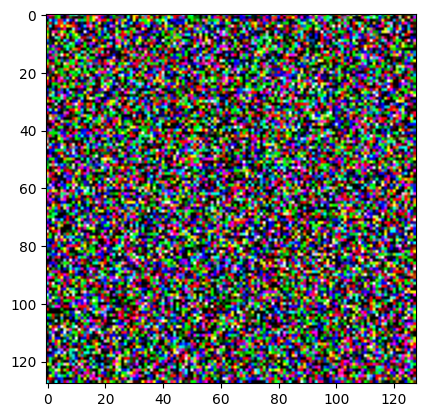

In [14]:
## initialize as the content image
# ip_image = content_image.clone()

## initialize as random noise
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

### **(b) 모델 훈련 loop**
- 훈련시킬 epoch 수, 스타일 및 콘텐츠 손실 제공을 위한 상대적 가중치 정의
- 학습률 0.1, 경사 하강법 기반의 최적화를 위한 Adam 옵티마이저로 인스턴스화

(+) 각 과정은 교재에 자세히 설명되어 있음

In [15]:
num_epochs = 300
wt_style = 1e6
wt_content = 1

style_losses = []
content_losses = []

opt = optim.Adam([ip_image.requires_grad_()], lr=0.1)

In [24]:
### 그람 행렬 정의

def gram_matrix(ip):
  num_batch, num_channels, height, width = ip.size()
  feats = ip.view(num_batch * num_channels, width * height)
  # 내적 계산
  gram_mat = torch.mm(feats, feats.t())

  return gram_mat.div(num_batch * num_channels * width * height) # 행렬 정규화

epoch number 50
style loss = 0.3821069300174713, content loss = 2.2257561683654785


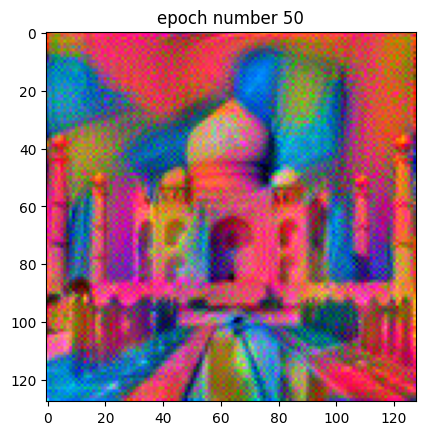

epoch number 100
style loss = 0.3652360141277313, content loss = 2.1777524948120117


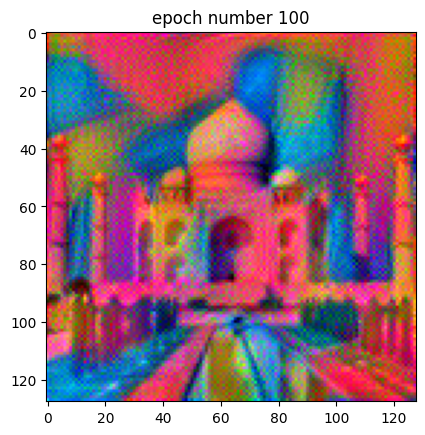

epoch number 150
style loss = 0.35459035634994507, content loss = 2.1438605785369873


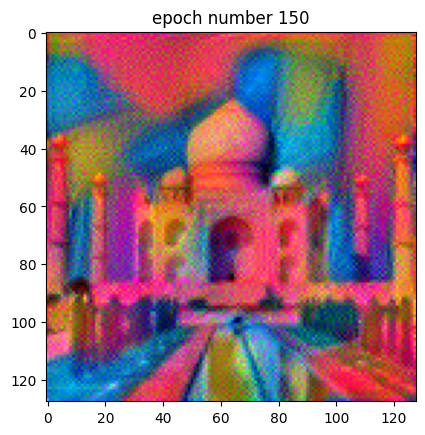

epoch number 200
style loss = 0.34689223766326904, content loss = 2.119292974472046


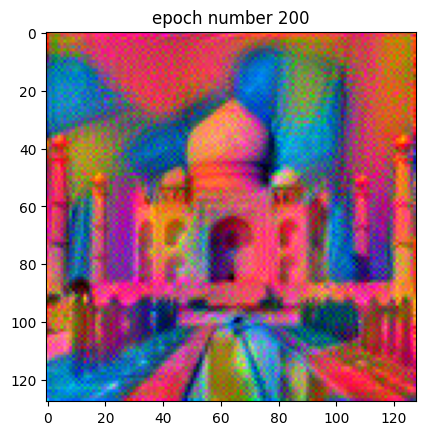

epoch number 250
style loss = 0.3412722647190094, content loss = 2.101240634918213


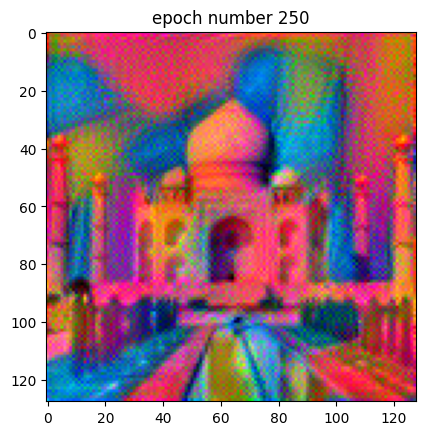

epoch number 300
style loss = 0.34275496006011963, content loss = 2.0877573490142822


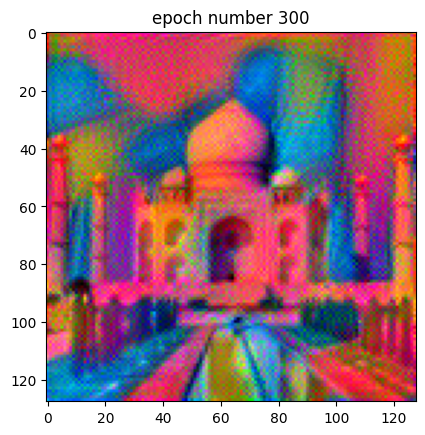

In [26]:
for curr_epoch in range(1, num_epochs+1):
    ### 스타일과 콘텐츠 손실 초기화
    ip_image.data.clamp_(0, 1) # 수치적 안정성을 위해 이미지 픽셀 값을 잘라냄
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        ## 콘텐츠 손실
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach() # detach(): 해당 값은 고정된 값이다~
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        ## 스타일 손실
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image)) # 스타일 손실의 경우 그람 행렬도 계산
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    ### 최종 손실 계산
    # 앞에서 정의한 가중치로 전체 스타일 손실과 콘텐츠 손실의 가중합을 계산
    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()

    # k 세대마다 손실과 생성된 이미지 확인
    if curr_epoch % 50 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        style_losses += [epoch_style_loss]
        content_losses += [epoch_content_loss]

    opt.step()

- 모델이 랜덤 노이즈 이미지에 스타일 이미지의 스타일을 적용하는 것으로 시작
- 훈련이 진행됨에 따라 콘텐츠 손실이 역할을 하기 시작함
  => 스타일이 지정된 이미지에 콘텐츠를 부여

### **(c) 손실 곡선 확인**

In [ ]:
plt.plot(range(50, 300+1, 50), style_losses, label='style_loss');
plt.plot(range(50, 300+1, 50), content_losses, label='content_loss');
plt.legend();

(에러) loss 저장이 잘못되는듯...ㅜ